Desenvolvido por: Heitor santos
Empresa: Dataex
Códificação para tratar as macros do Tesouraria fase 2. Realizando a leitura de arquivos do Google Cloud Storage, tratar as informações e realizar o insert no Google Big Query para seguir com o processo de cargar.

#Definição dos importes do código.

In [1]:
import math
import pandas as pd
#import scipy as interpolate
import numpy as np
import scipy.stats

from scipy import interpolate
from numpy.random import normal
from google.cloud import bigquery,storage
from google.oauth2 import service_account


# Remover do código
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')



#print(type(f))

Variaveis pré definidas

In [2]:
key_path = "D:\MeusDocumentos\Clientes\Dataex\BancoABC\dev-terceiros.json"

v_QUERY_STG_TB_VOL_IND = """
    SELECT Data_ref, Data_proc, Data, Delta, Delta_1, Delta_10, Delta_25, Delta_37, Delta_50, Delta_63, Delta_75, Delta_90, Delta_99 FROM `abc-pipeline-dev-terceiros.DS_RISCOS_RESULTADOS.STG_TB_VOL_IND` LIMIT 10 
    """
    
v_bucket_name = "abc-pipeline-dev-terceiros_cloudbuild" #Definição do nome do Bucket a ser utilizado para conectar no GCP

v_source_blob_name = "STAGE_AREA/IBOVOPT_VANILLA.CSV" #Definição do nome do arquivo com o caminho e sem o bucket a ser buscado para conectar no GCP

v_destination_file_name = "D:\MeusDocumentos\Clientes\Dataex\BancoABC\Tesouraria Fase 02\DEV - Macros\python\TesourariaFase2\IBOVOPT_VANILLA.CSV" #Definição do nome do caminho a ser salvo o arquivo do GCP com o nome a ser utilizado

Realiza download do arquivo no Cloud Storage

In [3]:
def download_file_cs(bucket_name, source_blob_name, destination_file_name):
    
    try:
        
        storage_client = storage.Client.from_service_account_json(key_path)

        bucket = storage_client.bucket(bucket_name)    

        blob = bucket.blob(source_blob_name)
        blob.download_to_filename(str(destination_file_name))


        print(
            "Downloaded storage object {} from bucket {} to local file {}.".format(
                source_blob_name, bucket_name, destination_file_name
            )
        )
    except Exception as e:
        print(e)

In [4]:
def read_file_csv(read_file):

    try:
        df = pd.read_csv(read_file, encoding='ANSI',  delimiter=';')
        df.rename(columns={"id_src" : "id" , "Cliente_src" : "Cliente" , "Notional_src" : "Notional" , "Call_Put_src" : "Call_Put" , "Strike_src" : "Strike" , "Premio_Tesouraria_BRL_src" : "Premio_Tesouraria_BRL" , "Trade_Date_src" : "Trade_Date" , "Initial_Date_src" : "Initial_Date" , "Fixing_Date_src" : "Fixing_Date" , "Vencimento_src" :"Vencimento" , "Vencimento_Referencia_src" : "Vencimento_Referencia" , "Veiculo_Legal_src" :"Veiculo_Legal" , "Trading_Banking_src" : "Trading_Banking" , "Livro_src" : "Livro" , "Estrategia_src" : "Estrategia" , "Estrategia_Nivel_2_src" : "Estrategia_Nivel_2" , "Liquidacao_Antecipada_x_src" : "Liquidacao_Antecipada_x" , "Data_Liquidacao_src" :"Data_Liquidacao" , "Qtd_Liquid_Vcto_du_src" : "Qtd_Liquid_Vcto_du" , "Premio_Tesouraria_Liq_curva_src" : "Premio_Tesouraria_Liq_curva" , "Taxa_Desconto_src" :"Taxa_Desconto" , "ID_REGISTRO_src" : "ID_REGISTRO", "Data_proc_src" : "Data_Proc" , "Data_base_d0_src" : "Data_base_d0" , "Data_base_d1_src" : "Data_base_d1" , "Data_base_m1_src" : "Data_base_m1" , "Dia_util_d0_src" :"Dia_util_d0" , "Dia_util_d1_src" : "Dia_util_d1" , "Dia_util_m1_src" : "Dia_util_m1" , "Data_src" : "Data_referencia" , "m_trade_date_initial_dc" : "m_trade_date_initial_dc" , "m_trade_date_initial_du" : "m_trade_date_initial_du" , "m_trade_date_fixing_dc" :"m_trade_date_fixing_dc" , "m_trade_date_fixing_du" : "m_trade_date_fixing_du" , "m_trade_date_vencimento_dc" : "m_trade_date_vencimento_dc" , "m_trade_date_vencimento_du" :"m_trade_date_vencimento_du" , "m_data_base_initial_dc" : "m_data_base_initial_dc" , "m_data_base_initial_du" : "m_data_base_initial_du" , "m_data_base_fixing_dc" :"m_data_base_fixing_dc" , "m_data_base_fixing_du" : "m_data_base_fixing_du" , "m_data_base_vencimento_dc" : "m_data_base_vencimento_dc" , "m_data_base_vencimento_du" :"m_data_base_vencimento_du" , "m_taxa_pre_brl_initial_date_perc" :"m_taxa_pre_brl_initial_date_perc" , "m_taxa_pre_brl_fixing_date_perc" : "m_taxa_pre_brl_fixing_date_perc" , "m_taxa_pre_brl_vencimento_perc" :"m_taxa_pre_brl_vencimento_perc" , "m_indice_futuro" : "m_indice_futuro" , "m_vol_perc" :"m_vol_perc" , "m_premio_corrigido" : "m_premio_corrigido" , "m_preco_opcao" : "m_preco_opcao", "pl_ltd_opcao" : "pl_ltd_opcao" , "pl_daily" : "pl_daily" , "pl_month" : "pl_month"}, inplace = True)
        df['Trade_Date']= pd.to_datetime(df['Trade_Date'].str.slice(0, 10), format='%m/%d/%Y')
        df['Initial_Date']= pd.to_datetime(df['Initial_Date'].str.slice(0, 10), format='%m/%d/%Y')
        df['Fixing_Date']= pd.to_datetime(df['Fixing_Date'].str.slice(0, 10), format='%m/%d/%Y')
        df['Vencimento']= pd.to_datetime(df['Vencimento'].str.slice(0, 10), format='%m/%d/%Y')
        #df['Data_Liquidacao']= pd.to_datetime(file['Data_Liquidacao'].str.slice(0, 10), format='%m/%d/%Y')
        
        
        for i in range(len(df)) :

            if ( df["Trade_Date"][i] <  df["Vencimento"][i]) :
                print("verdadeiro")
            else:
                print("falso")

        #df.info()


    except Exception as e:
        
        print(e)

Abre conexão com o BQ e cria o dataframe com a consulta com consulta de SELECT

In [5]:
def open_cnx_bq(sql):
    try:
        credentials = service_account.Credentials.from_service_account_file(
            key_path,
            scopes=["https://www.googleapis.com/auth/cloud-platform"],
        )

        client = bigquery.Client(
            credentials=credentials,
            project=credentials.project_id
        )
        
        rows = (
            client.query(sql)
            .result()
            .to_dataframe()
        )

        df = pd.DataFrame(rows)
        
        client.close()
        
        return df
    
    except Exception as e:
        print(e)


In [17]:
def BASE_TREINO(df):

    v_TABELA_VOL = df[df.columns[4:]].to_numpy()

    x = df[df.columns[3]].to_numpy()
    y = [0.01, 0.10, 0.25, 0.37, 0.50, 0.63, 0.75, 0.90, 0.99]

    f = interpolate.interp2d(y, x, v_TABELA_VOL, kind='cubic')

    return f

In [7]:
def CALC_D1(FWD1, strike1, Vol1, T21):
    
    D1 = (math.log(FWD1 / strike1) + ((math.pow(Vol1, 2) / 2) * T21)) / (Vol1 * math.sqrt(T21))
    
    return D1

In [8]:
def CALC_D2(FWD2, strike2, Vol2, T22):
    
    D2 = math.log(FWD2 / strike2) - ((math.pow(Vol2, 2) / 2) * T22) / (Vol2 * math.sqrt(T22))
    
    return  D2

In [9]:
def DERIVATIVOS_OPCAO_IBOV(TIPO, FWD, strike, Vol, PRE, T):
    
    if T > 1:
        
        if TIPO == "0":

            DOI = 0
            
        else:
            
            T2  = T/252
            
            r = math.log(1+PRE)
            
            d1 = CALC_D1(FWD, strike, Vol, T)
    
            d2 = CALC_D2(FWD, strike, Vol, T)
            
            if TIPO == "CALL":
                DOI = math.exp(-r * T2) * (FWD * normal(d1) - strike * normal(d2))
            elif TIPO == "PUT":
                DOI = math.exp(-r * T2) * (FWD * normal(-d1) - strike * normal(-d2))
            else:
                DOI = "ERRO"
        
    else:
        
        DOI = abs(FWD - strike)

        if (TIPO == "CALL" and (FWD - strike) < 0): DOI = 0

        if (TIPO == "PUT" and (strike - FWD) < 0): DOI = 0

        if (TIPO == "0"): DOI = 0
        
    return DOI  

In [19]:
def DERIVATIVOS_VOL_OPCAO_IBOV(FWD, strike, Vol, PRE, T, treino):

    if strike != 0 and T > 1:

        T2 = T / 252
        
        l = 1 + PRE
        # print("l:", l )
        r = math.log(l)
        
        # print("T2:", T2)
        # print("r:", r)  
          
        VOL2 = Vol + 0.00002
        # print("PRIMEIRO VOL2:", VOL2)
        i = 0
        while abs(VOL2 - Vol) > 0.00001:

            Vol = VOL2
            
            d1 = CALC_D1(FWD, strike, Vol, T2)
            print("antes interpolacao VOL2:", VOL2)
            
            delta = math.exp(-r * T2) * (1-scipy.stats.norm(d1, 1).cdf(0))
            
            VOL2 = treino(delta, [T])
            
            if i==0:
            #     print("T:",T )
            #     print("depois interpolacao VOL2 VOL2:", VOL2)
            #     print("delta:",delta)
                     print("d1:",d1)
            #     print("vol:",Vol)
                      
            i = i + 1
            if i == 1000:
                exit()
                
        # print("ultimo i:", i)
        # print("ULTIMA VOL2:", VOL2) 

    return VOL2


In [11]:
def DERIVATIVOS_DELTA_OPCAO_IBOV(TIPO, FWD, strike, Vol, PRE, T):
    
    if T > 1:
        if TIPO == 0:
            DDOI = 0
        
        else:
            
            T2 = T / 252
            r = math.log(1 + PRE)
            
            d1 = CALC_D1(FWD, strike, Vol, T)
            d2 = CALC_D2(FWD, strike, Vol, T)
        
            if TIPO == "CALL":
                DDOI = math.exp(-r * T2) * normal(d1)
            elif TIPO == "PUT":
                DDOI = math.exp(-r * T2) * normal(d1) - 1
            Else: DDOI = "ERRO"

    else:
        DDOI = 0

In [20]:


df_DVOI = open_cnx_bq(v_QUERY_STG_TB_VOL_IND)

v_BASE_TREINO_DVOI = BASE_TREINO(df_DVOI)

v_media_delta_50 = np.mean(df_DVOI["Delta_50"])

v_FWD = 94042
v_strike = 104000
v_Vol = v_media_delta_50
print("media:", v_media_delta_50 )
v_PRE = 0.0194
v_T = 32

print(DERIVATIVOS_VOL_OPCAO_IBOV(v_FWD, v_strike, v_Vol, v_PRE, v_T, v_BASE_TREINO_DVOI))


media: 0.20160925010000003
antes interpolacao VOL2: 0.20162925010000002
d1: -1.3648969356280813
antes interpolacao VOL2: [0.16426161]
antes interpolacao VOL2: [0.16825385]
antes interpolacao VOL2: [0.16768905]
antes interpolacao VOL2: [0.16776732]
antes interpolacao VOL2: [0.16775644]
[0.16775795]


[[-0.0652361  -0.59221922  0.9936343  ...  0.95741247 -0.42938365
  -0.26218186]
 [-0.59221922  0.97183655 -0.8330493  ... -0.91862924  0.90984188
  -0.42033111]
 [ 0.9936343  -0.8330493   0.15981624 ...  0.33396267 -0.92253445
   0.9514469 ]
 ...
 [ 0.95741247 -0.91862924  0.33396267 ...  0.49731789 -0.97671985
   0.88096742]
 [-0.42938365  0.90984188 -0.92253445 ... -0.97671985  0.81510061
  -0.24140188]
 [-0.26218186 -0.42033111  0.9514469  ...  0.88096742 -0.24140188
  -0.44867525]]


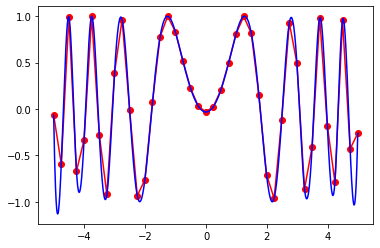

In [13]:
#REMOVER

from scipy import interpolate
import numpy as np
# import matplotlib as plt
from matplotlib import pyplot as plt




x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)

print(z)

f = interpolate.interp2d(x, y, z, kind='cubic')



xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)
znew = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()